# Preprocessing Pipeline


The goal of the preprocessing pipeline here is to serve as a draft. Before we perform spike inference. This could be using oases or other more sophisticated method.


In [3]:
import utils as U
import importlib
import numpy as np
importlib.reload(U)

data = U.load_data()

# Time stamps for the Measured Signal. 

The timestamp for the measured signal consists of $105868$ measured time stamps over the full experimental range. The sampling 
rate we deduce from the timesamps is roughly $30.14$ Hz. 

In [14]:
print(f"Number of samples: {data['t'].shape[0]}")
# Deduced sampling rate
sampling_rate = 1 / np.mean(np.diff(data['t']))
print(f"Deduced sampling rate: {sampling_rate} Hz")

Number of samples: 105968
Deduced sampling rate: 30.144897456157484 Hz


# DFF Signal 

The DFF signal extends to the entire duration of the experiment which is $189 \times 105968$ samples of data. For each of the $189$ neurons. The main task for preprocessing this signal is to correct for any drift in the data before running spike inference on the dataset. 

In [45]:
def neuron_signal_segment(neuron_idx, start_t, end_t, sampling_rate):
    # DEFINE SEGMENT & TIME VECTOR
    sr_new = int(sampling_rate)  # Hz after downsampling
    start_idx = start_t * sr_new
    end_idx = end_t * sr_new
    time = np.linspace(start_t, end_t, end_idx - start_idx, endpoint=False)
    cell_gcamp = neuron_idx
    gcamp_cal_seg = data["dff"][cell_gcamp, start_idx:end_idx]
    return time, gcamp_cal_seg

In [46]:
from scipy.signal import butter, filtfilt, savgol_filter


def process_neuron_signal(neuron_cal_segment, sampling_rate):    
    # PARAMETERS
    fs = int(sampling_rate)  # Hz (after downsampling)
    hp_cutoff = 0.01  # Hz, to remove very slow drifts
    savgol_window = 21  # samples (~0.6 s window)
    savgol_poly = 2  # quadratic fit for Savitzky–Golay

    def preprocess_calcium(data):
        # High-pass Butterworth filter
        b, a = butter(N=4, Wn=hp_cutoff / (fs / 2), btype='highpass')
        filtered = filtfilt(b, a, data, axis=0)

        # Savitzky–Golay filter
        smoothed = savgol_filter(filtered, window_length=savgol_window, polyorder=savgol_poly, axis=0)
        return smoothed  

    gcamp_cal_filt = preprocess_calcium(neuron_cal_segment)

    return gcamp_cal_filt

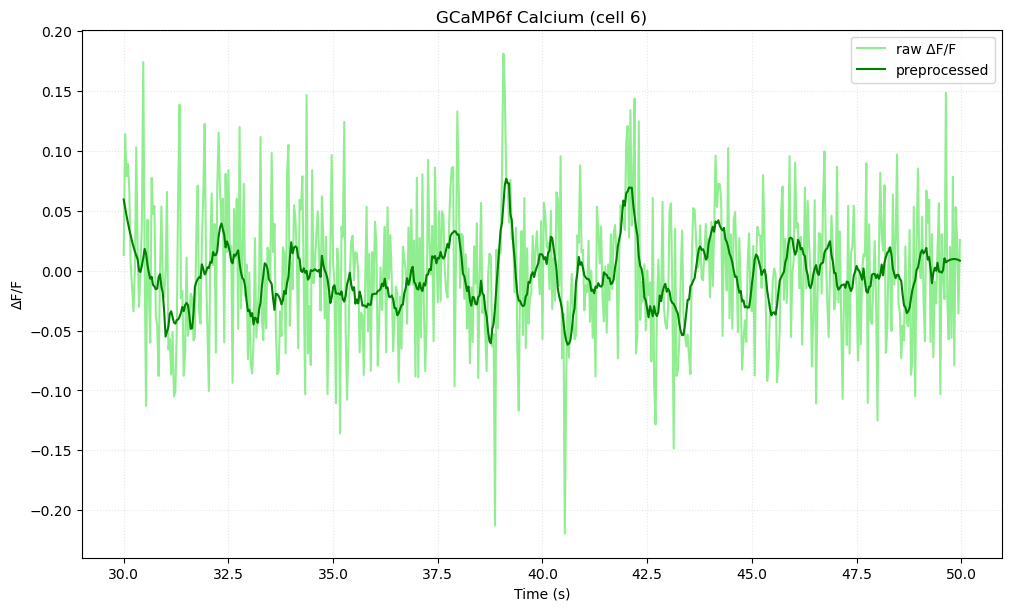

In [51]:
import matplotlib.pyplot as plt


time, gcamp_cal_seg = neuron_signal_segment(6, 30, 50, sampling_rate)
gcamp_cal_filt = process_neuron_signal(gcamp_cal_seg, sampling_rate)


fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(10, 6), constrained_layout=True)
# GCaMP6f panel
axs.plot(time, gcamp_cal_seg, color="lightgreen", label="raw ΔF/F")
axs.plot(time, gcamp_cal_filt, color="green", label="preprocessed")
axs.set_title("GCaMP6f Calcium (cell 6)")
axs.set_xlabel("Time (s)")
axs.set_ylabel("ΔF/F")
axs.legend()
axs.grid(alpha=0.3, linestyle=":")
